<a href="https://colab.research.google.com/github/SuryARavichan/Chatbot/blob/main/S13_MA_Different_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import random
random.seed(1)

AR: Autoregression. A model that uses the dependent relationship between an observation
and some number of lagged observations.


I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation
from an observation at the previous time step) in order to make the time series stationary.

MA: Moving Average. A model that uses the dependency between an observation and
residual errors from a moving average model applied to lagged observations.

ARIMA (p,d,q)
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q:The size of the moving average window, also called the order of moving average.

Box - Jenkinss (1970): any TS can be approximated by ARMA (if stationary) or ARIMA (if non-stationary)

Structure in the residual error can also be modeled directly. There may be complex signals
in the residual error that are difficult to directly incorporate into the model. Instead, you can create a model of the residual error time series and predict the expected error for your model. The predicted error can then be subtracted from the model prediction and in turn provide an additional lift in performance.

Autoregression model of the residual error time series.

In [ ]:
F=pd.read_csv('/content/drive/My Drive/Time Series/daily-total-female-births.csv',header=0,parse_dates=[0],index_col=0,squeeze=True)
F.head(20)


Date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
1959-01-06    29
1959-01-07    45
1959-01-08    43
1959-01-09    38
1959-01-10    27
1959-01-11    38
1959-01-12    33
1959-01-13    55
1959-01-14    47
1959-01-15    45
1959-01-16    37
1959-01-17    50
1959-01-18    43
1959-01-19    41
1959-01-20    52
Name: Births, dtype: int64

In [ ]:
F.shape

(365,)

<Axes: xlabel='Date'>

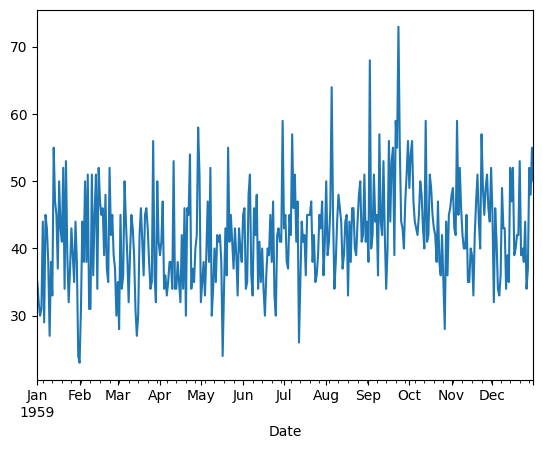

In [ ]:
F.plot()

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

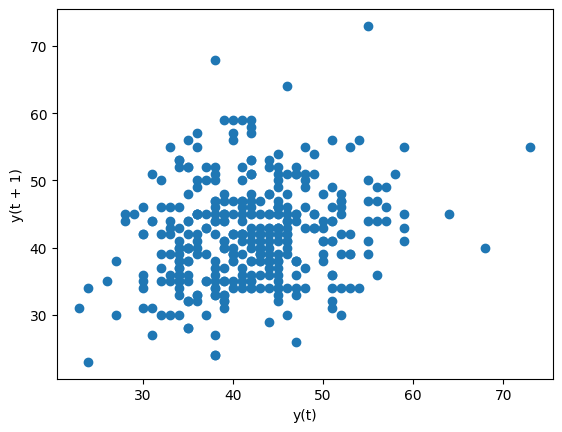

In [ ]:
#Autocorrelation Plot
pd.plotting.lag_plot(F)

In [ ]:
values=pd.DataFrame(F.values)
df=pd.concat([values.shift(1), values],axis=1)
df.columns=['t','t+1']
res=df.corr()
print(res)

            t       t+1
t    1.000000  0.217877
t+1  0.217877  1.000000


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

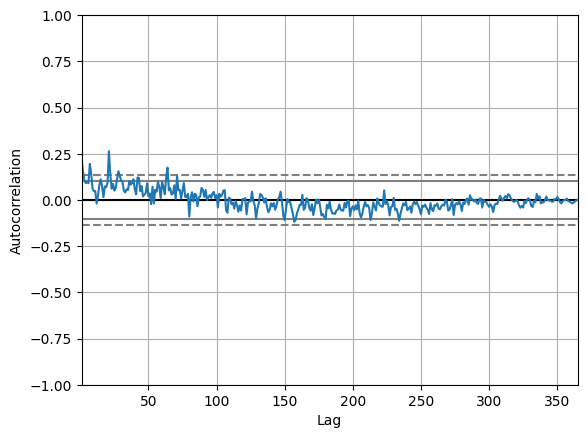

In [ ]:
pd.plotting.autocorrelation_plot(F)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

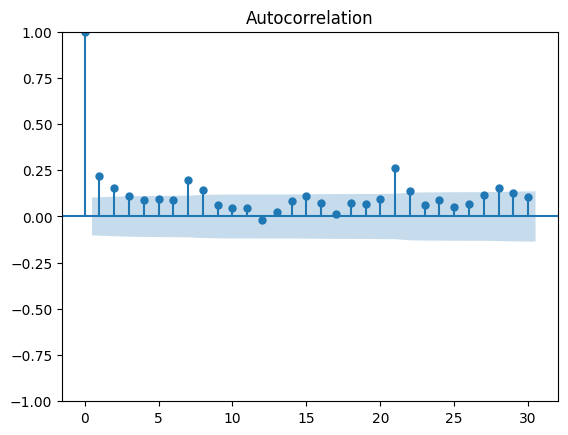

In [ ]:
plot_acf(F,lags=30)
plt.show()

Evaluate a Persistence Model

Test RMSE: 9.151


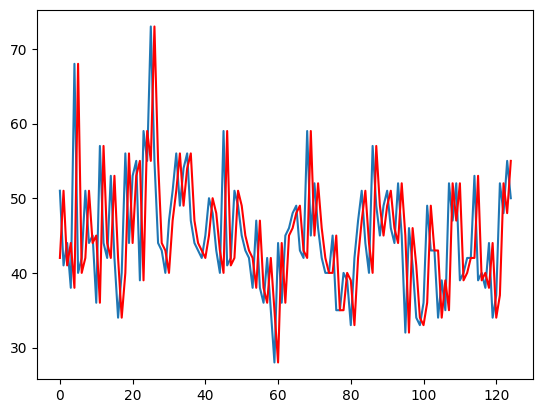

In [ ]:
#Train/Test split
from sklearn import metrics
X=df.values
train_size=int(len(X)*0.66)
train,test=X[1:train_size],X[train_size:]
train_X,train_Y=train[:,0],train[:,1]
test_X,test_Y=test[:,0],test[:,1]
#persistence model
def model_persistence(x):
  return x
#walk-forward validation
predictions=list()
for x in test_X:
  yhat=model_persistence(x)
  predictions.append(yhat)
rmse=np.sqrt(metrics.mean_squared_error(test_Y,predictions))
print('Test RMSE: %.3f'%rmse)
#plot predictions vs expected
plt.plot(test_Y)
plt.plot(predictions,color='red')
plt.show()


AUTO REGRESSION OF RESIDUAL ERROR

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
#persistence model to calculate training error
train_pred=[x for x in train_X]
#calculate training residuals
train_resid=[train_Y[i]-train_pred[i] for i in range(len(train_pred))]
len(train_resid)

239

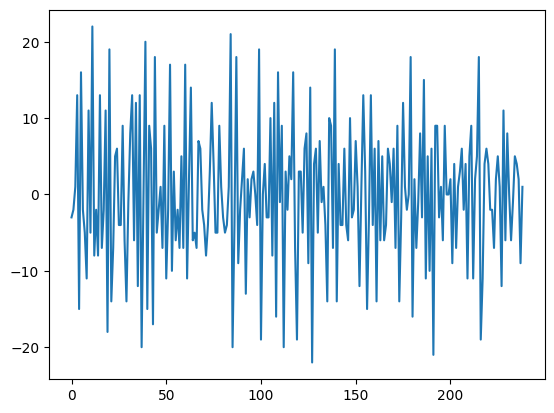

In [ ]:
plt.plot(train_resid)

In [ ]:
TR=pd.Series(train_resid)

In [ ]:
#model the training set residuals
model=AutoReg(train_resid,lags=15)
model_fit=model.fit()
window=model_fit.ar_lags
window

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
coef=model_fit.params
print('coef=%s'%(coef))

coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


In [ ]:
#Walk forward over time steps in test
history=train_resid[len(train_resid)-len(window):]
history=[history[i] for i in range(len(history))]

In [ ]:
predictions=list()
expected_error=list()
for t in range(len(test_Y)):
  #persistence
  yhat=test_X[t]
  error=test_Y[t]-yhat
  expected_error.append(error)
  #predict error
  length=len(history)
  lag=[history[i] for i in range(length-len(window),length)]
  pred_error=coef[0]
  for d in range(len(window)):
    pred_error+=coef[d+1]*lag[len(window)-d-1]
  predictions.append(pred_error)
  history.append(error)
  #print('Predicted error=%f,expected error=%f'%(pred_error,error))
  

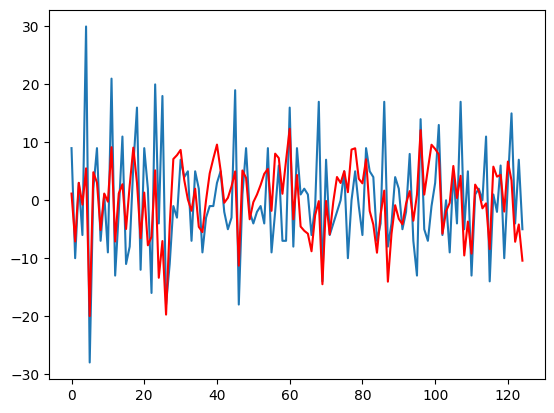

In [ ]:
#plot predicted error
plt.plot(expected_error)
plt.plot(predictions,color='red')
plt.show()

Correct Predictions with a Model of Residuals
* improved_forecast=forecast + estimated_error

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
predictions=list()
expected_error=list()
for t in range(len(test_Y)):
  #persistence
  yhat=test_X[t]
  error=test_Y[t]-yhat
  expected_error.append(error)
  #predict error
  length=len(history)
  lag=[history[i] for i in range(length-len(window),length)]
  pred_error=coef[0]
  for d in range(len(window)):
    pred_error+=coef[d+1]*lag[len(window)-d-1]
  #correct predictions
  yhat=yhat+pred_error
  predictions.append(yhat)
  history.append(error)
  #print('Predicted error=%f,expected error=%f'%(pred_error,error))
rmse=np.sqrt(metrics.mean_squared_error(test_Y,predictions))
print('Test RMSE:%.3f'%rmse)
  

Test RMSE:7.649


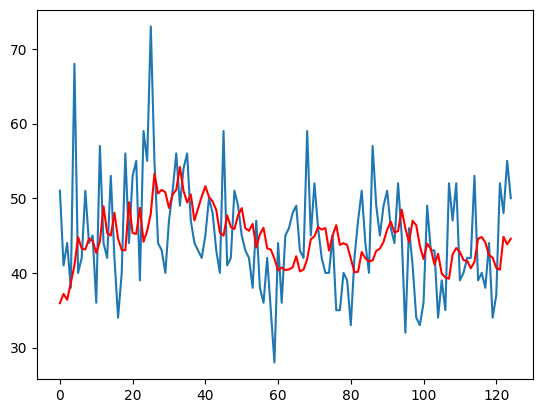

In [ ]:
plt.plot(test_Y)
plt.plot(predictions,color='red')
plt.show()

We can see that the persistence model has been aggressively corrected back to a time
series that looks something like a moving average.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

Solving by ARIMA approach

In [ ]:
from sklearn.metrics import mean_squared_error

# split into train and test sets
X = F.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
train

array([35, 32, 30, 31, 44, 29, 45, 43, 38, 27, 38, 33, 55, 47, 45, 37, 50,
       43, 41, 52, 34, 53, 39, 32, 37, 43, 39, 35, 44, 38, 24, 23, 31, 44,
       38, 50, 38, 51, 31, 31, 51, 36, 45, 51, 34, 52, 47, 45, 46, 39, 48,
       37, 35, 52, 42, 45, 39, 37, 30, 35, 28, 45, 34, 36, 50, 44, 39, 32,
       39, 45, 43, 39, 31, 27, 30, 42, 46, 41, 36, 45, 46, 43, 38, 34, 35,
       56, 36, 32, 50, 41, 39, 41, 47, 34, 36, 33, 35, 38, 38, 34, 53, 34,
       34, 38, 35, 32, 42, 34, 46, 30, 46, 45, 54, 34, 37, 35, 40, 42, 58,
       51, 32, 35, 38, 33, 39, 47, 38, 52, 30, 34, 40, 35, 42, 41, 42, 38,
       24, 34, 43, 36, 55, 41, 45, 41, 37, 43, 39, 33, 43, 40, 38, 45, 46,
       34, 35, 48, 51, 36, 33, 46, 42, 48, 34, 41, 35, 40, 34, 30, 36, 40,
       39, 45, 38, 47, 33, 30, 42, 43, 41, 41, 59, 43, 45, 38, 37, 45, 42,
       57, 46, 51, 41, 47, 26, 35, 44, 41, 42, 36, 45, 45, 45, 47, 38, 42,
       35, 36, 39, 45, 43, 47, 36, 41, 50, 39, 41, 46, 64, 45, 34, 38, 44,
       48, 46, 44, 37, 39

In [ ]:
history = [x for x in train]

predicted=45.468313, expected=51.000000
predicted=45.086211, expected=41.000000
predicted=43.571749, expected=44.000000
predicted=43.729333, expected=38.000000
predicted=42.481865, expected=68.000000
predicted=47.175121, expected=40.000000
predicted=44.947788, expected=42.000000
predicted=43.954966, expected=51.000000
predicted=44.883563, expected=44.000000
predicted=45.205101, expected=45.000000
predicted=43.586061, expected=36.000000
predicted=44.483834, expected=57.000000
predicted=44.544584, expected=44.000000
predicted=45.738144, expected=42.000000
predicted=43.871405, expected=53.000000
predicted=45.744604, expected=42.000000
predicted=45.235678, expected=34.000000
predicted=42.677707, expected=40.000000
predicted=43.916833, expected=56.000000
predicted=45.150994, expected=44.000000
predicted=44.708213, expected=53.000000
predicted=46.131049, expected=55.000000
predicted=47.028043, expected=39.000000
predicted=44.787459, expected=59.000000
predicted=46.208231, expected=55.000000


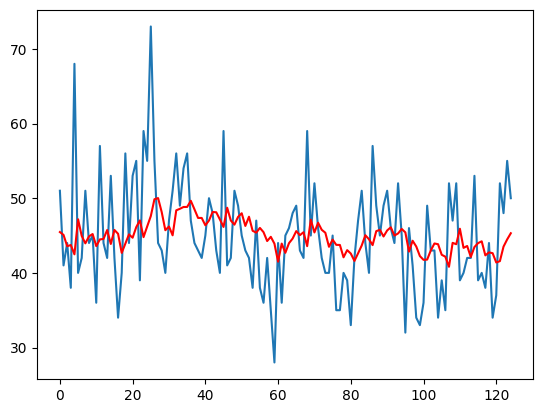

In [ ]:
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(6,1,2))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
 best_model = ARIMA(train, order=(6,1,2))
 best_model_fit = best_model.fit()

In [ ]:
best_model_fit.aic

1617.1673030435973

In [ ]:
history = [x for x in train]

predicted=40.454167, expected=51.000000
predicted=40.497921, expected=41.000000
predicted=40.500074, expected=44.000000
predicted=40.514403, expected=38.000000
predicted=40.503947, expected=68.000000
predicted=42.895876, expected=40.000000
predicted=42.770690, expected=42.000000
predicted=40.619580, expected=51.000000
predicted=43.074450, expected=44.000000
predicted=43.114298, expected=45.000000
predicted=43.194700, expected=36.000000
predicted=40.673080, expected=57.000000
predicted=43.453656, expected=44.000000
predicted=43.477675, expected=42.000000
predicted=43.414489, expected=53.000000
predicted=43.823853, expected=42.000000
predicted=43.741282, expected=34.000000
predicted=43.335004, expected=40.000000
predicted=43.211489, expected=56.000000
predicted=43.681836, expected=44.000000
predicted=43.694604, expected=53.000000
predicted=44.073757, expected=55.000000
predicted=44.566562, expected=39.000000
predicted=44.302405, expected=59.000000
predicted=44.986372, expected=55.000000


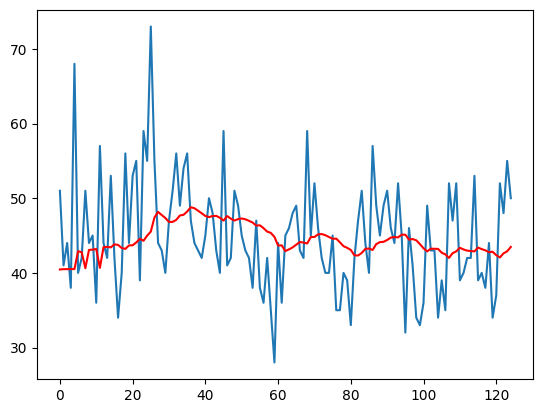

In [ ]:
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ExponentialSmoothing(history)
 model_fit = model.fit()
 output = model_fit.predict()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()